# Energies and logits, linear

Results referenced in 25b_Section_2_research.ipynb.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json

from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F

import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Logits ~ Energy

In [2]:
from itertools import permutations


task_types = (
    datasets.ClassificationTaskType.ONE_VS_ONE,
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
)

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_Linear_ML/")
)

def task_generator(task_types=task_types, loader=loader):
    """
    Generate tasks for which to compute attributions.
    """
    # Generate 1v1
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1, ag_2 in permutations(config.ANTIGENS, r=2):
        for seed_id, split_id in seed_split_ids:            
            task = datasets.ClassificationTask(
                task_type=datasets.ClassificationTaskType.ONE_VS_ONE,
                ag_pos=ag_1,
                ag_neg=ag_2,
                seed_id=seed_id,
                split_id=split_id,
            )
            yield task
    
    # Generate the rest: 1v9, high vs 95low, high vs looser
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1 in config.ANTIGENS:
        for seed_id, split_id in seed_split_ids:
            for task_type in task_types:
                
                if task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
                    continue
                
                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )
                yield task

Energy contributions ~ Attributions correlations

In [3]:
from utils_07 import get_attr_from_records, get_onehotstack_from_records
from utils_07 import load_energy_contributions_from_task_linear_version

In [4]:
energy_contributions_path = "../data/Frozen_MiniAbsolut_Linear_ML/07e_EnergyContributions_shuffled.tsv"
# energy_contributions_path = "../data/Frozen_MiniAbsolut_Linear_ML/07e_EnergyContributions_1v1.tsv"
force_run_contrib = False
skip_errors_contrib = True

if Path(energy_contributions_path).exists() and not force_run_contrib:
    df_attrib = pd.read_csv(energy_contributions_path, sep="\t")
else:

    records = []
    # for task in task_generator():
    for task in task_generator():
        
        if skip_errors_contrib:
            try:
                stats = load_energy_contributions_from_task_linear_version(task, attributions_toload="v0.1.2-3_shuffled_weights")
            except:
                continue
        else:
            stats = load_energy_contributions_from_task_linear_version(task, attributions_toload="v0.1.2-3_shuffled_weights")
        
        records.append(stats)
     
    df_attrib = pd.DataFrame.from_records(records)
    df_attrib.to_csv(energy_contributions_path, index=False, sep='\t')

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scip

In [5]:
df_attrib.head()

,task_type,ag_pos,ag_neg,seed_id,split_id,mean,std,mean_pos,std_pos,mean_neg,...,mean_pos_fold,std_pos_fold,mean_neg_fold,std_neg_fold,mean_total,std_total,mean_pos_total,std_pos_total,mean_neg_total,std_neg_total
0,1v1,3VRL,1NSN,0,42,0.035698,0.260791,0.035698,0.260791,NaN,...,0.050812,0.247234,NaN,NaN,0.054979,0.215665,0.054979,0.215665,NaN,NaN
1,1v1,3VRL,1NSN,1,42,-0.227137,0.257561,-0.227137,0.257561,NaN,...,0.227251,0.294848,NaN,NaN,-0.150329,0.242096,-0.150329,0.242096,NaN,NaN
2,1v1,3VRL,1NSN,2,42,0.173511,0.263225,0.173511,0.263225,NaN,...,0.198711,0.288050,NaN,NaN,0.227981,0.285314,0.227981,0.285314,NaN,NaN
3,1v1,3VRL,1NSN,3,42,-0.116973,0.254395,-0.116973,0.254395,NaN,...,0.115121,0.257277,NaN,NaN,-0.081066,0.249173,-0.081066,0.249173,NaN,NaN
4,1v1,3VRL,3RAJ,0,42,0.139702,0.272267,0.139702,0.272267,NaN,...,-0.044414,0.272345,NaN,NaN,0.119074,0.239848,0.119074,0.239848,NaN,NaN


In [6]:
## Test if needed?

# Duplicate 1v1 and reverse pos with negative to account for double contributions
df_attrib_1v1 = df_attrib.loc[df_attrib["task_type"] == "ONE_VS_ONE"].copy()
ag_pos_col = df_attrib_1v1["ag_pos"]
df_attrib_1v1["ag_pos"] = df_attrib_1v1["ag_neg"]
df_attrib_1v1["ag_neg"] = ag_pos_col
del ag_pos_col

In [7]:
# sns.catplot(
#     data=df_attrib, 
#     x="task_type", 
#     y="mean_pos", 
#     hue="ag_pos")

In [8]:
# sns.catplot(
#     data=df_attrib, 
#     x="task_type", 
#     y="std", 
#     hue="ag_pos")

In [9]:
# # Combined plots from logits and contributions
# df_logits["corr_type"] = "logits"

# df_attrib["corr_type"] = "attributions"
# df_attrib["r_pos"] = df_attrib["mean_pos"]

# df_combined = pd.concat([df_logits, df_attrib])

# fig, ax = plt.subplots(figsize=(10, 10))
# sns.boxplot(data=df_combined, x="task_type", y="r_pos", hue="corr_type", ax=ax)

In [10]:
# df_combined["type"] = df_combined["task_type"] + "_" + df_combined["corr_type"]

# fig, ax = plt.subplots(figsize=(10, 10))
# sns.stripplot(
#     data=df_combined, 
#     x="type", 
#     y="r_pos", 
#     hue="ag_pos",
#     order= [
#         "1v1_logits", "1v1_attributions", "1v9_logits", "1v9_attributions",
#         "high_vs_95low_logits", "high_vs_95low_attributions", "high_vs_looser_logits", "high_vs_looser_attributions"
#     ],
#     jitter=0.2,
#     ax=ax,
# )
# # Rotate x-axis labels 90
# for item in ax.get_xticklabels():
#     item.set_rotation(90)

/tmp/ipykernel_3243535/1820297903.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


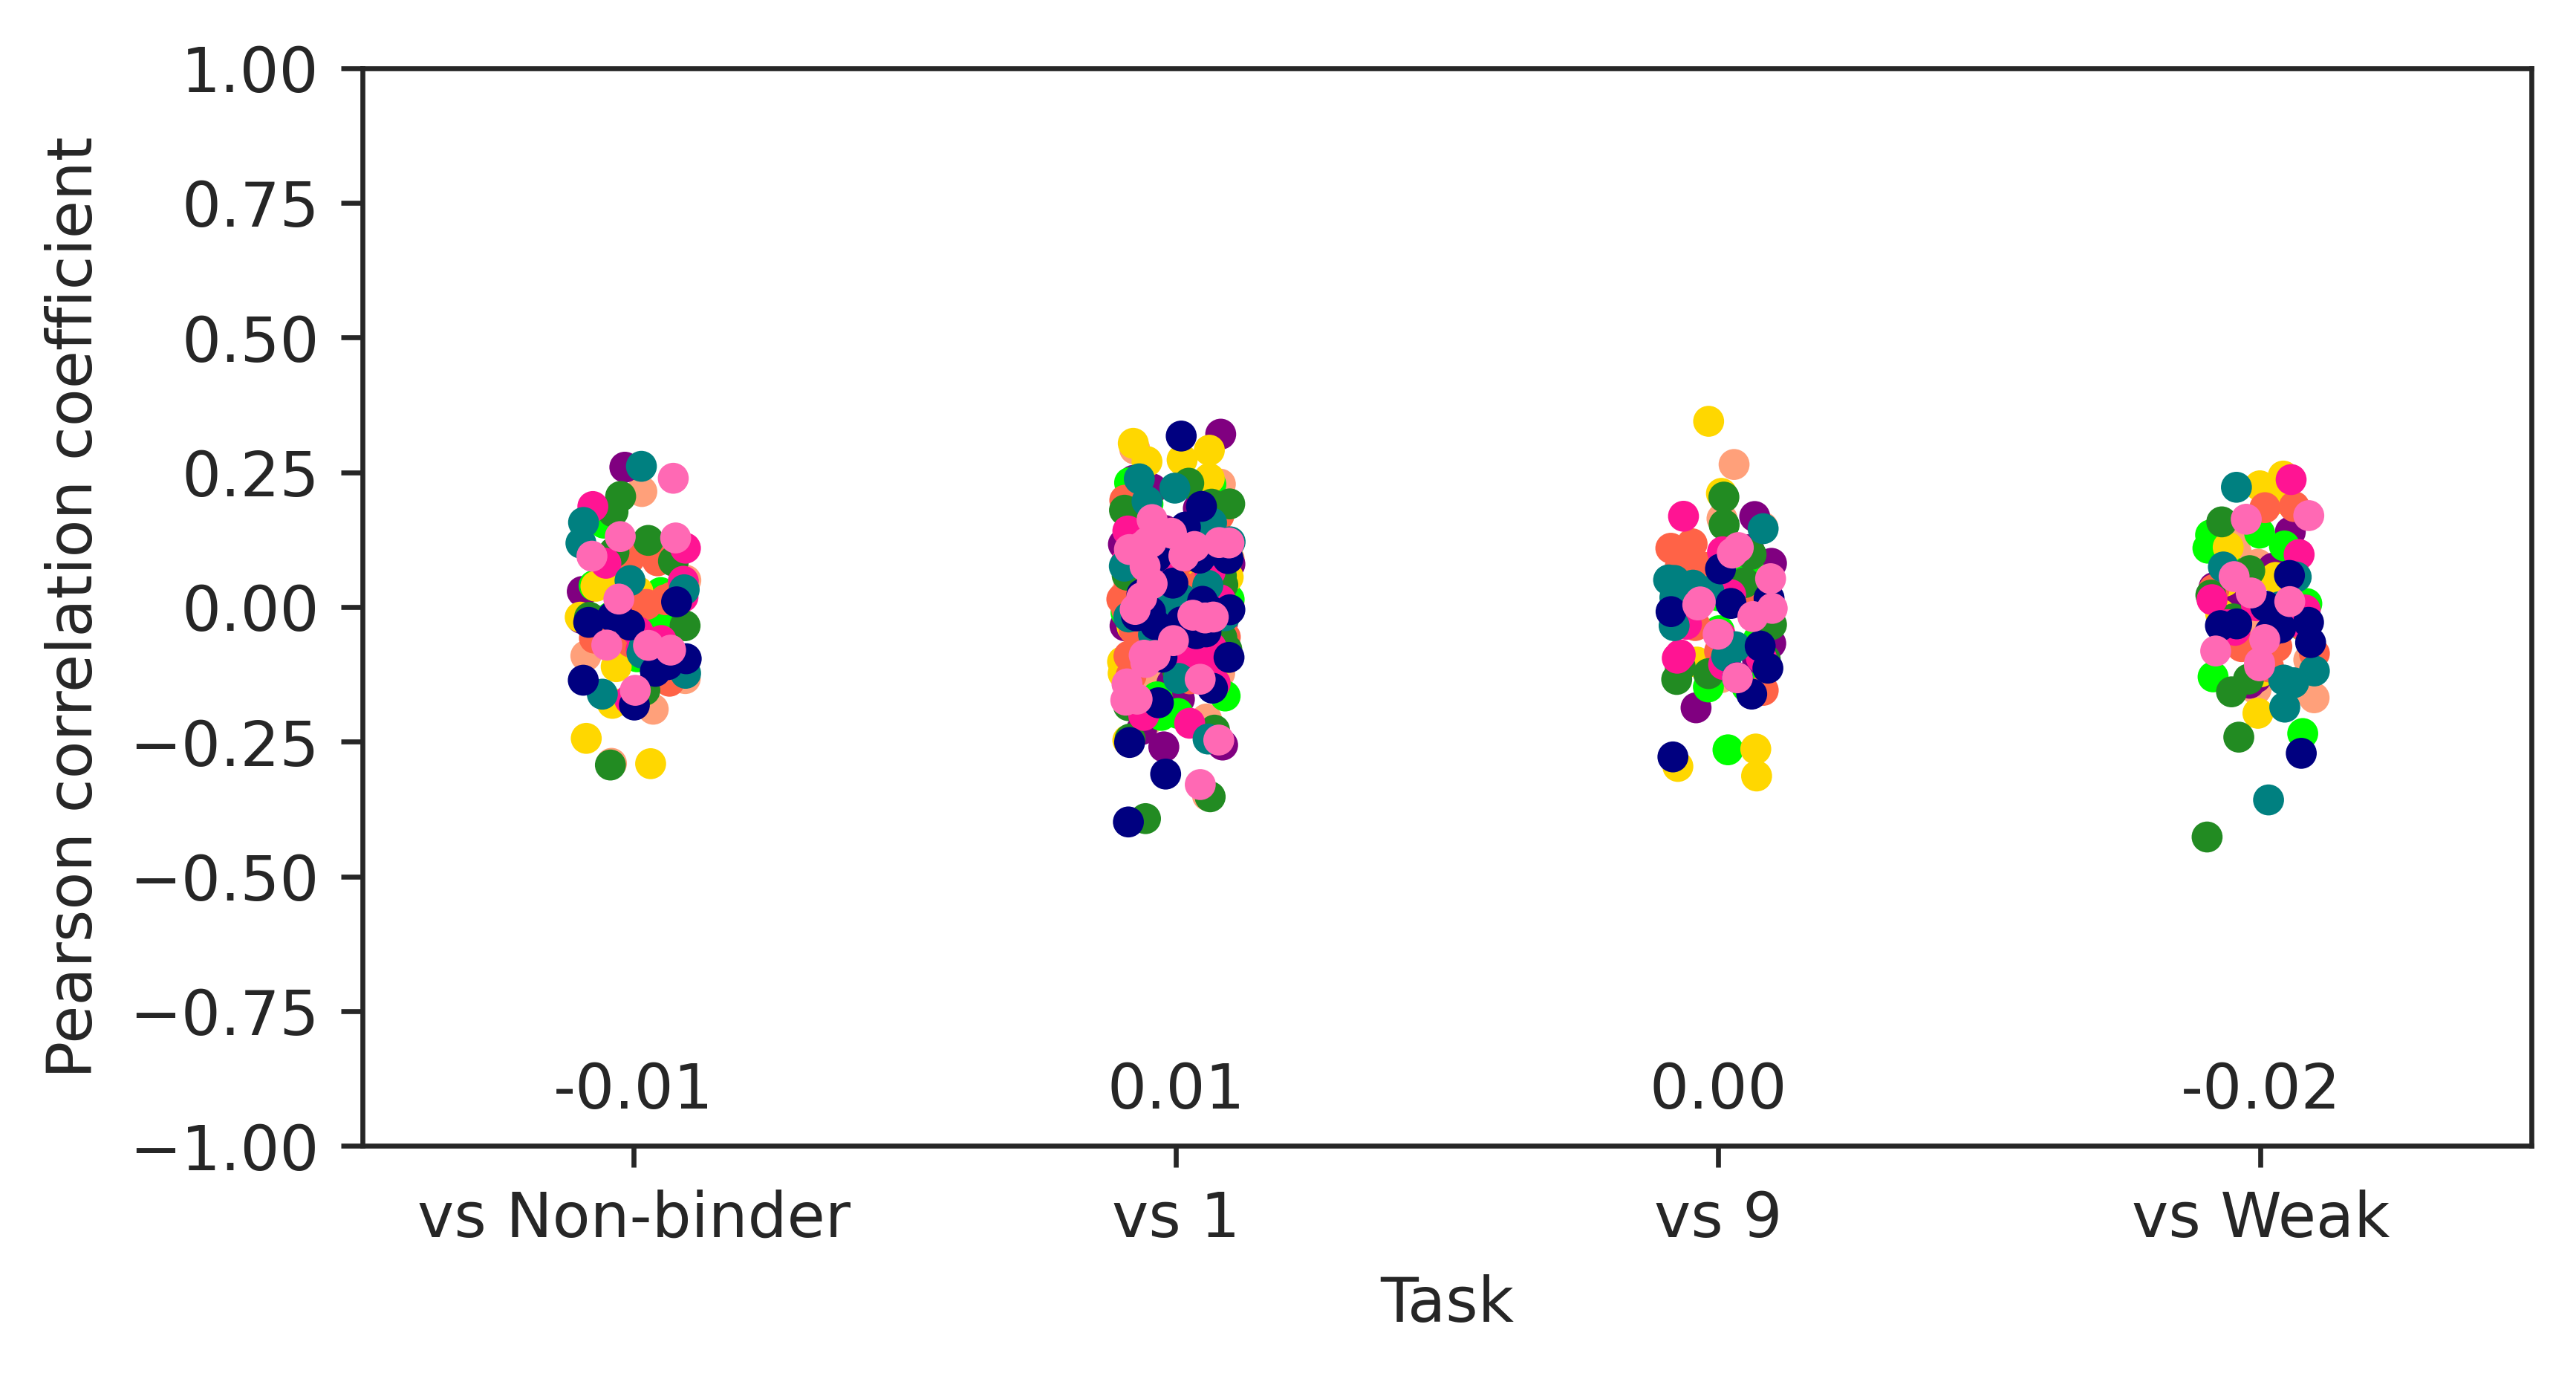

In [11]:
sns.set_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

palette = {'1FBI': '#008080',
 '3VRL': '#FFA07A',
 '2YPV': '#000080',
 '5E94': '#FFD700',
 '1WEJ': '#228B22',
 '1OB1': '#FF69B4',
 '1NSN': '#800080',
 '1H0D': '#FF6347',
 '3RAJ': '#00FF00',
 '1ADQ': '#FF1493'} 

task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_attrib, 
    x="task_type", 
    y="mean_pos_total", 
    order=task_order,
    hue="ag_pos",
    ax=ax,
    # cmap=visualisations.PlotParams.cmap_antigens,
    palette=palette,
)

ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_attrib.groupby(["task_type"]).agg({"mean_pos_total": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.93,
        f"{row['mean_pos_total']:.2f}",
        # Center center
        horizontalalignment='center',
    )

# ax.set_title("Mean{Correlation(Energycontribution, Attribution)} for positive class")
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")
ax.set_ylim(-1, 1)

# Save fig as .svg
fig.savefig(
    "S2F_Linear_Attributions-Energy.svg",
    bbox_inches='tight',
    dpi=600,
    transparent=True,
)

In [12]:
# Anova test that all are different
from scipy.stats import f_oneway
f_oneway(
    df_attrib.query("task_type == 'high_vs_95low'")["mean_pos_total"],
    df_attrib.query("task_type == '1v1'")["mean_pos_total"],
    df_attrib.query("task_type == '1v9'")["mean_pos_total"],
    df_attrib.query("task_type == 'high_vs_looser'")["mean_pos_total"],
)

F_onewayResult(statistic=1.2023526638097461, pvalue=0.3081562962193964)

In [13]:
# define_task_col(df_attrib)
# df_attrib_agg = df_attrib.groupby(["task", "task_type"]).agg({"mean_pos_total": "mean"}).reset_index()
# df_contributions_merged = pd.merge(df_acc_agg, df_attrib_agg, on=["task", "task_type"], how='inner')
# df_contributions_merged

In [14]:
# from scipy.stats import pearsonr

# cmap = visualisations.PlotParams.cmap_tasks

# sns.set_theme(context="paper")
# sns.set_style("white")
# fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# # Map to tasks clean
# df_contributions_merged["task_type_clean"] = df_contributions_merged["task_type"].map(visualisations.PlotParams.map_task_type_to_clean)

# # Line plot in seaborn with R2 regression
# for i, df_g in df_contributions_merged.groupby("task_type_clean"):
#     print(i)
#     color = cmap[visualisations.PlotParams.order_tasks_clean.index(i)] # type: ignore
#     sns.regplot(
#         x="acc_closed",
#         y="mean_pos_total",
#         data=df_g,
#         scatter=True,
#         color=color,
#         ax=ax,
#         label=i,
#     )

#     # Compute Pearson correlation
#     r, pval = pearsonr(df_g["mean_pos_total"], df_g["acc_closed"])
#     # Add text with r and R2 at centroid
#     y = df_g["mean_pos_total"].mean()
#     x = df_g["acc_closed"].mean()
#     ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

# FONT_SIZE = 12
# ax.tick_params(labelsize=FONT_SIZE)
# ax.legend(
#     bbox_to_anchor=(0.5, -0.3),
#     loc="center",
#     borderaxespad=0.0,
#     fontsize=7,
#     title="Task",
#     title_fontsize=8,
#     ncol=10,
#     frameon=False,
# )
# ax.set_ylabel("Per-residue Energy-logit correlation", fontsize=FONT_SIZE)
# ax.set_xlabel("SN10 Accuracy", fontsize=FONT_SIZE)

# # ax.set_yticks(yticks)

# # Title
# # ax.set_title("Relationship beteen SN10 accuracy and Jensen-Shannon Divergence (JSD)", fontsize=FONT_SIZE)

# # fig.savefig("figures/1B.svg")
# fig.show()

Plotting individual energy contributions correlations

In [15]:
# def plot_energy_contributions_per_task(task, slide_class = "positive", plot_perc = False, ax = None):
#     _, slide_df = load_energy_contributions_from_task_linear_version(task, load_slide_df=True)
#     all_energies = []
#     all_energies_perc = []
#     all_attrs = []
#     all_attrs_perc = []

#     for i, row in slide_df.iterrows():
#         if row["class"] != slide_class:
#             continue
#         energies = row["energies"]
#         all_energies += energies
#         all_energies_perc += (np.array(energies) / np.sum(energies)).tolist()

#         attrs = row["attributions"]
#         all_attrs += attrs.tolist()
#         all_attrs_perc += (np.array(attrs) / np.sum(np.abs(attrs))).tolist()

#     if ax is None:
#         fig, ax = plt.subplots(figsize=(10, 5))
#     if plot_perc:
#         ax.plot(
#             all_attrs_perc, 
#             all_energies_perc, 
#             'o', 
#             alpha=0.1,
#             color="#f1593a", # red
#             )
#     else:
#         ax.plot(all_attrs, all_energies, 'o', alpha=0.1)

#     # Compute correlation and add text

#     r, p = pearsonr(all_energies_perc, all_attrs_perc)
#     r2 = r ** 2
#     ax.text(
#         0.23,
#         0.03,
#         f"r = {r:.2f}\n$r^2$ = {r2:.2f}",
#         bbox=dict(facecolor="white", alpha=0.5),
#     )

In [16]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
#     ag_pos="5E94",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, ax=ax)
# ax.set_title("Energy contributions vs attributions for (5E94 vs 9)")

In [17]:
# sns.scatterplot(
#     data=df,
#     x="Energy",
#     y="logits",
#     hue="class",
#     ax=ax,
#     palette=cmap,
# )

In [18]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
#     ag_pos="5E94",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)
# sns.set_theme(context="paper")
# sns.set_style("white")

# cmap = ["#f1593a"]  # red

# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("5E94 vs 9")
# ax.set_ylabel("Energy contribution (fraction)")
# ax.set_xlabel("Attribution (signed fraction)")

In [19]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
#     ag_pos="1NSN",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("Energy contributions vs attributions for (1NSN vs 9)")
# ax.set_ylabel("Energy contribution (%)")
# ax.set_xlabel("Attribution (signed %)")

In [20]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.HIGH_VS_LOOSER,
#     ag_pos="5E94",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("Energy contributions vs attributions for (5E94 high vs looser)")
# ax.set_ylabel("Energy contribution (%)")
# ax.set_xlabel("Attribution (signed %)")

In [21]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.HIGH_VS_LOOSER,
#     ag_pos="1NSN",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("Energy contributions vs attributions for (1NSN high vs looser)")
# ax.set_ylabel("Energy contribution (%)")
# ax.set_xlabel("Attribution (signed %)")

Error analysis on AA Contributions

In [22]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
#     ag_pos="5E94",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=42,
# )
# _, slide_df = load_energy_contributions_from_task_linear_version(task, load_slide_df=True)

In [23]:
# slide_df["attributions_sum"] = slide_df["attributions"].apply(lambda x: np.sum(x))

# # Plot r_total vs attributions_sum
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(slide_df["attributions_sum"], slide_df["r_total"], 'o', alpha=0.1)

In [24]:
# # Collect all energies with indexes in list from slide_df and plot distribution
# energies = []
# indexes = []
# for i, row in slide_df.iterrows():
#     energies_i = row["energies"]
#     energies += energies_i
#     indexes_i = list(range(0, 11))
#     indexes += indexes_i

# sns.histplot(
#     data=pd.DataFrame({"energies": energies, "indexes": indexes}),
#     x="energies",
# )

# sns.displot(
#     data=pd.DataFrame({"energies": energies, "indexes": indexes}),
#     x="indexes",
#     y="energies",
#     cmap="viridis",
#     rug=False,
#     cbar=True,
# )

In [25]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
#     ag_pos="1NSN",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=42,
# )
# _, slide_df = load_energy_contributions_from_task_linear_version(task, load_slide_df=True)

In [26]:
# # Collect all energies with indexes in list from slide_df and plot distribution
# energies = []
# indexes = []
# for i, row in slide_df.iterrows():
#     energies_i = row["energies"]
#     energies += energies_i
#     indexes_i = list(range(0, 11))
#     indexes += indexes_i

# sns.histplot(
#     data=pd.DataFrame({"energies": energies, "indexes": indexes}),
#     x="energies",
# )

# sns.displot(
#     data=pd.DataFrame({"energies": energies, "indexes": indexes}),
#     x="indexes",
#     y="energies",
#     cmap="viridis",
#     rug=False,
#     cbar=True,
# )

In [27]:
# for ag in config.ANTIGENS:
#     task = datasets.ClassificationTask(
#         task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
#         ag_pos=ag,
#         ag_neg="auto",
#         seed_id=0,
#         split_id=42,
#     )
#     _, slide_df = load_energy_contributions_from_task_linear_version(task, load_slide_df=True)
    
#     energies = []
#     indexes = []
#     for i, row in slide_df.iterrows():
#         energies_i = row["energies"]
#         energies += energies_i
#         indexes_i = list(range(0, 11))
#         indexes += indexes_i

#     fig, ax = plt.subplots(figsize=(10, 5))
#     sns.histplot(
#         data=pd.DataFrame({"energies": energies, "indexes": indexes}),
#         x="energies",
#     )
#     ax.set_title(f"Energy contribution distribution for {ag}")